# Plant image classification model
This notebook will cover the steps of training and infering plant type from an image.

These are the steps in this notebook:
1. Setup workspace
2. Fetching the dataset
3. Exploratory Data Analysis
4. Training, Validation and Test Split

## 1. Setup Workspace
The first step to work clean, is to create a clean workspace. <br/>
And download all the necessary files from pypi

Don't forget to install all the necessary dependencies from `requirements.txt` file.
using the command: `pip install -r requirements.txt`

In [42]:
import os
from enum import StrEnum
from dataclasses import dataclass

class Paths(StrEnum):
    DATA = 'data'
    OUTPUT = 'output'

@dataclass
class DatasetClass():
    abs_path: str
    count: int
    images_dims: list[tuple] = None

for folder_name in Paths:
    os.makedirs(folder_name, exist_ok=True)

DATASET_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
DATASET_FILENAME = os.path.join(Paths.DATA, 'flower_photos.tgz')

## 2. Fetching the dataset
In this step we will fetch and extract the dataset to our filesystem for the following steps.

After we have created the workspace directories. We need to get some data. For that we will download the flower photos dataset from the given URL link (or you can download it manually from the tensorflow site).

In [3]:
import requests
from tqdm import tqdm

def download(url: str, filename: str) -> None:
    """
    Downloading a file and showing some indecation about the download using `tqdm`

    Args:
        `url: str` - The URL to download from the file
        `filename: str` - The path to save the downloaded file in the machine
    """
    with open(filename, 'wb') as f:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total = int(r.headers.get('content-length', 0))

            # tqdm has many interesting parameters. Feel free to experiment!
            tqdm_params = {
                'desc': url,
                'total': total,
                'miniters': 1,
                'unit': 'B',
                'unit_scale': True,
                'unit_divisor': 1024,
            }
            
            with tqdm.tqdm(**tqdm_params) as progress_bar:
                for chunk in r.iter_content(chunk_size=8192):
                    progress_bar.update(len(chunk))
                    f.write(chunk)

download(DATASET_URL, DATASET_FILENAME)

Exctracting the dataset from the compressed file

In [4]:
import tarfile
from tarfile import TarInfo

def extract_file(filename: str, extraction_path: str) -> None:
    """
    Extracting all the contents of tarfile

    Args:
        `filename: str` - The path to the compressed tarfile
        `extraction_path: str` - The path to the target directory which will contain the extracted contents
    """
    with tarfile.open(filename, 'r:gz') as tar:
        total_files: list[TarInfo] = tar.getmembers()

        with tqdm(total=len(total_files), unit='file', desc='Extracting') as progress_bar:
            for member in total_files:
                tar.extract(member, extraction_path)
                progress_bar.update(1)

extract_file(os.path.join(Paths.DATA, 'flower_photos.tgz'), Paths.DATA)

Extracting:   0%|          | 0/3677 [00:00<?, ?file/s]C:\Users\user\AppData\Local\Temp\ipykernel_10300\3578066170.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(member, extraction_path)
Extracting: 100%|██████████| 3677/3677 [00:18<00:00, 201.14file/s]


## 3. Exploratory Data Analysis
In this step, we will plot the dataset and try to understand what it contains.

### Quantity
Checking for the available classes in our dataset and checking whether they imbalanced

Text(0, 0.5, 'Images count')

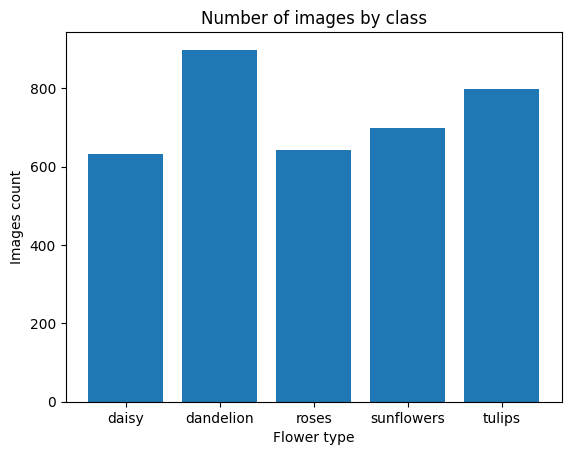

In [46]:
import matplotlib.pyplot as plt

DATASET_PARENT_PATH = os.path.join(Paths.DATA, 'flower_photos')
contents = os.listdir(DATASET_PARENT_PATH)
dataset_classes: dict[str, DatasetClass] = {}

for filename in contents:
    abs_path = os.path.join(DATASET_PARENT_PATH, filename)
    if os.path.isdir(abs_path):
        dataset_classes[filename] = DatasetClass(
            abs_path=abs_path, 
            count=len(os.listdir(abs_path))
        )

# Extracting the count of each class from the nested object
class_count: list[int] = [dataset_class.count for dataset_class in dataset_classes.values()]

# Showing the plot
plt.bar(dataset_classes.keys(), class_count)
plt.title("Number of images by class")
plt.xlabel("Flower type")
plt.ylabel("Images count")


It's seems that the `dandelion` class is bigger than the others. Let's check by how much?

In [47]:
min_class_count: int = min(class_count)
max_class_count: int = max(class_count)

print(f'The smallest class count: {min_class_count}')
print(f'The largest class count: {max_class_count}')

min_class_percent: float = (min_class_count * 100) / max_class_count
print('In percentage: ' + "{:.2f}".format(100 - min_class_percent))

The smallest class count: 633
The largest class count: 898
In percentage: 29.51


It's nearly 30 percent !

### Input layer size
Plotting the dimensions of inputs (images)

C:\Users\user\AppData\Local\Temp\ipykernel_10300\1675097614.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


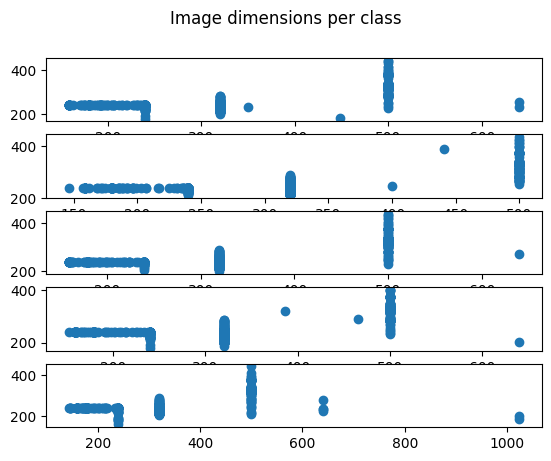

In [54]:
from PIL import Image
import numpy as np

def get_dims(file_path: str) -> tuple[int, int]:
    """
    Returns dimenstions for an RBG image

    Args:
        `file_path: str` - The path to the target image

    Returns:
        Tuple contains the width and height of the image
    """
    im = Image.open(file_path)
    arr = np.array(im)
    h,w,d = arr.shape
    return w, h


def batch_dimension_calc(folder_path: str) -> np.ndarray:
    """
    Calculating dimensions of each image in the folder

    Args:
        `folder_path: str` - The path of the folder containing the images
    """
    images_dims: list[tuple] = []

    for image_path in os.listdir(folder_path):
        image_rel_path: str = os.path.join(folder_path, image_path)
        images_dims.append(get_dims(image_rel_path))

    return np.array(images_dims)


def plot_dimensions(axis: plt, dataset_class: DatasetClass) -> None:
    """
    """
    width: list = []
    height: list = []
    for dims_tuple in dataset_class.images_dims:
        width.append(dims_tuple[0])
        height.append(dims_tuple[1])

    axis.scatter(np.array(width), np.array(height))


fig, axis = plt.subplots(len(dataset_classes.keys()))
fig.suptitle("Image dimensions per class")
current_axis: int = 0

# Calculating the dimensions of each image in each class
for class_name in dataset_classes:
    class_folder_path: str = dataset_classes[class_name].abs_path
    dataset_classes[class_name].images_dims = batch_dimension_calc(class_folder_path)
    plot_dimensions(axis[current_axis], dataset_classes[class_name])
    current_axis += 1

fig.show()